## Applied - Question 10

This question relates to the College dataset

#### Import block

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('seaborn-white')

Importing the data

In [36]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}College.csv')

# Transform categorical to dummy
df['Private'] = df['Private'].astype('category').cat.codes

# Get X, y
y = df.Outstate
X = df.drop('Outstate', axis=1)

#### (a) Forward Stepwise

The best results on Training set occurs between 9 to 12 features. 

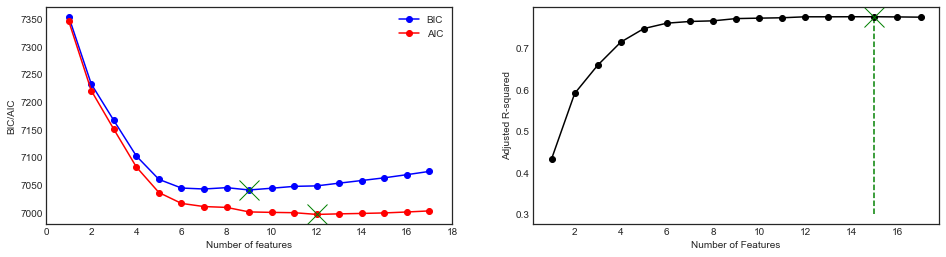

In [37]:
from forward_select import forward_select
from operator import itemgetter

# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, 
                                                    test_size=0.5, shuffle=True)

# Forward stepwise
df_forward = forward_select(y_train, X_train, k=X_train.shape[1])

# Plot 
bics = df_forward.bic
aics = df_forward.aic
adj_R_squared = df_forward.adj_R_squared
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
max_adjR_index, max_adjR = max(enumerate(adj_R_squared), key=itemgetter(1))

# Set up plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Left plot
ax1.plot(df_forward.num_features, bics, color='b', label='BIC', marker='o')
ax1.plot(df_forward.num_features, aics, color='r', label='AIC', marker='o')
ax1.plot(min_bic_index + 1, min_bic, color='g', marker='x', markersize=20)
ax1.plot(min_aic_index + 1, min_aic, color='g', marker='x', markersize=20)
ax1.set_ylabel('BIC/AIC')
ax1.set_xlabel('Number of features')
ax1.set_xticks(np.arange(0, 20, step=2))
ax1.legend()

# Right plot
ax2.plot(df_forward.num_features, adj_R_squared, color='k', marker='o')
ax2.plot(max_adjR_index + 1, max_adjR, color='g', marker='x', markersize=20)
ax2.set_ylabel('Adjusted R-squared')
ax2.set_xlabel('Number of Features')
ax2.set_xticks(np.arange(0, 20, step=2))
ax2.vlines(max_adjR_index + 1, ymin=0.3, ymax=max_adjR, linestyles='--', color='g')

In [38]:
# The best nine features model includes
best_features = df_forward.features[8]
print('The best 9 features model includes:\n', best_features)

The best 9 features model includes:
 ['Room.Board', 'perc.alumni', 'Expend', 'Private', 'PhD', 'Grad.Rate', 'Personal', 'Accept', 'Enroll']


#### (b) GAMs

The result is...disoriented. However, there are some basic relationship we can identify
Some interesting relationships are:
1. On average, more enroll means less out of states tuition
2. On average, schools that accept more students charges more out of stats tuition
3. On average, private schools charge a massive more for our of stats student
4. On average, expenditure has a U-shape with out-of-state tuition. 

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:21: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     39.6753
Link Function:                     IdentityLink Log Likelihood:                                 -6180.6525
Number of Samples:                          388 AIC:                                            12442.6557
                                                AICc:                                           12452.4452
                                                GCV:                                          4039825.1628
                                                Scale:                                          3303779.88
                                                Pseudo R-Squared:                                   0.8271
Feature Function                  Lam

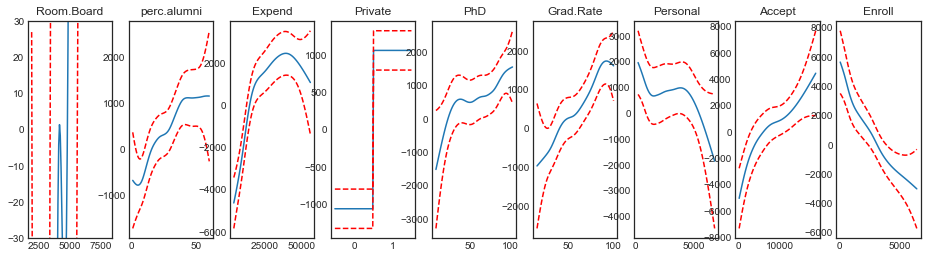

In [42]:
from pygam import LinearGAM, s,  f

X_train_gam = np.array(X_train[best_features])
y_train_gam = np.array(y_train)

gam = LinearGAM(s(0) + s(1) + s(2) + f(3) + s(4) + s(5)+ s(6)+ s(7)+ s(8))
gam.gridsearch(X_train_gam, y_train_gam)

## plotting
fig, axs = plt.subplots(1, 9, figsize=(16,4))

titles = best_features
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

gam.summary()

#### (c) GAMs on test set

Using RMSE to compare with OLS including 9 best features. We can see that GAMs gains
about (1981.58-1852.62)/1981.58 = 6.5 % less RMSE than OLS.

In [54]:
# Set up dict for easy comparison
RMSE_dict = {} 

# Prediction using GAMs
y_pred = gam.predict(np.array(X_test[best_features]))

# Calculate RMSE of OLS vs GAMs
RMSE_dict['GAMs'] = np.sqrt(mean_squared_error(y_test, y_pred))
RMSE_dict['OLS'] = np.sqrt(df_forward.RSS[8]/X_train.shape[0])

# Display dataframe
pd.DataFrame.from_dict(RMSE_dict, orient='index', columns=['RMSE'])

,RMSE
GAMs,1852.620868
OLS,1981.579448


#### (d) Non-linear variables
Looking at the GAMs plot we did in part (c) we can see perc.alumni, Expend PhD, Personal
and Accept has a pretty clear non-linear relationship with Outstate. 